In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
# import repackage
# repackage.add('../../')
# repackage.add('../')

In [3]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

### load data sets

In [4]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


In [5]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
# ds['u_rho'] = grid.interp(ds.u,'X')
# ds['v_rho'] = grid.interp(ds.v,'Y')

ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [6]:


# FilePath='/g/data/gv90/bkg581/prd_amery/amery_FIT0/' # Truth file settings
# prefix='roms_avg_'
# timeRange = [49, 54]
# datelist = np.array(range(timeRange[0],timeRange[1],1))


# fl=generateFileList(FilePath,prefix,datelist)
# print(fl)

# # ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

# ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

# print(ds.nbytes/1e9,'G')

# ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
# ds['my'] = ds.m*(60*60*24*365)
# print(ds.nbytes/1e9,'G')
# ds

# ds = ds.assign_coords({"x_rho": grd.x_rho})
# ds = ds.assign_coords({"y_rho": grd.y_rho})
# ds = ds.assign_coords({"lon_rho": grd.lon_rho})
# ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# # ds['hc'] = grd.hc
# # ds['s_w']=grd.s_w
# # ds['s_rho']=grd.s_rho
# # ds['Cs_w']=grd.Cs_w
# # ds['Cs_r']=grd.Cs_r


# # ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# # ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

# ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

# ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

# ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

# ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

# ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# # make masks

# poly_shelf = np.array([
#     [1.55e6,600000],
#     [2.25e6,600000],
#     [2.25e6,800000],
#     [2.20e6,830000],
#     [1.55e6,890000]])
# # plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# # plt.show()



# mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


# ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# # ds.mask_zice_roi.plot()
# roi_label1 = 'amery'
# ds.mask_zice_roi.attrs['long_name']=roi_label1

# # set any grid data here.

# weights_area = (1/ds.pm)*(1/ds.pn)
# weights_area.name = "weights"

# print('making vertical coordinates')
# Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
# z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
# Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
# z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
# ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
# ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# # ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

# ds, grid = ROMSmetricsAndGrid(ds)

# print('correctly mask melt')
# ds['m'] = ds.m*ds.mask_ziceNaN
# ds['my'] = ds.m*(60*60*24*365)


# print('mapping u/v to u/v rho')
# ds['u_rho'] = grid.interp(ds.u,'X')
# ds['v_rho'] = grid.interp(ds.v,'Y')

# ds_FIT0 = ds

# ds.close()

In [7]:


# FilePath='/g/data/gv90/bkg581/prd_amery/amery_AIS0/' # Truth file settings
# prefix='roms_avg_'
# timeRange = [49, 54]
# datelist = np.array(range(timeRange[0],timeRange[1],1))


# fl=generateFileList(FilePath,prefix,datelist)
# print(fl)

# # ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

# ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

# print(ds.nbytes/1e9,'G')

# ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
# ds['my'] = ds.m*(60*60*24*365)
# print(ds.nbytes/1e9,'G')
# ds

# ds = ds.assign_coords({"x_rho": grd.x_rho})
# ds = ds.assign_coords({"y_rho": grd.y_rho})
# ds = ds.assign_coords({"lon_rho": grd.lon_rho})
# ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# # ds['hc'] = grd.hc
# # ds['s_w']=grd.s_w
# # ds['s_rho']=grd.s_rho
# # ds['Cs_w']=grd.Cs_w
# # ds['Cs_r']=grd.Cs_r


# # ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# # ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

# ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

# ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

# ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

# ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

# ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# # make masks

# poly_shelf = np.array([
#     [1.55e6,600000],
#     [2.25e6,600000],
#     [2.25e6,800000],
#     [2.20e6,830000],
#     [1.55e6,890000]])
# # plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# # plt.show()



# mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


# ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# # ds.mask_zice_roi.plot()
# roi_label1 = 'amery'
# ds.mask_zice_roi.attrs['long_name']=roi_label1

# # set any grid data here.

# weights_area = (1/ds.pm)*(1/ds.pn)
# weights_area.name = "weights"

# print('making vertical coordinates')
# Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
# z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
# Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
# z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
# ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
# ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# # ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

# ds, grid = ROMSmetricsAndGrid(ds)

# print('correctly mask melt')
# ds['m'] = ds.m*ds.mask_ziceNaN
# ds['my'] = ds.m*(60*60*24*365)


# print('mapping u/v to u/v rho')
# ds['u_rho'] = grid.interp(ds.u,'X')
# ds['v_rho'] = grid.interp(ds.v,'Y')

# ds_AIS0 = ds

# ds.close()

In [8]:


FilePath='/g/data/jk72/deg581/apom/mdl/amery_AIS2/' # Truth file settings
prefix='roms_avg_'
timeRange = [46,51]#[49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


# print('mapping u/v to u/v rho')
# ds['u_rho'] = grid.interp(ds.u,'X')
# ds['v_rho'] = grid.interp(ds.v,'Y')

ds_AIS2 = ds

ds.close()

['/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0046.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0047.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0048.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0049.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS2/roms_avg_0050.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [9]:


FilePath='/g/data/jk72/deg581/apom/mdl/amery_AIS05/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


# print('mapping u/v to u/v rho')
# ds['u_rho'] = grid.interp(ds.u,'X')
# ds['v_rho'] = grid.interp(ds.v,'Y')

ds_AIS05 = ds

ds.close()

['/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0049.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0050.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0051.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0052.nc', '/g/data/jk72/deg581/apom/mdl/amery_AIS05/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [10]:
print(' make dayofyear means ')
print(' have to first fix the time coordinate to ignore the leap year. sigh.')

No_of_years=5
dayofyear = np.concatenate([np.array((356,361)),np.tile(np.arange(1,365,5),No_of_years-1),np.arange(1,365-10,5)])
dayofyear_da = xr.DataArray(dayofyear,[('day',dayofyear)])

ds_CTRL['day']=dayofyear_da
ds_CTRL['salt_doy']=ds_CTRL.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['my_doy']=ds_CTRL.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

# ds_FIT0['day']=dayofyear_da
# ds_FIT0['salt_doy']=ds_FIT0.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_FIT0['my_doy']=ds_FIT0.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

# ds_AIS0['day']=dayofyear_da
# ds_AIS0['salt_doy']=ds_AIS0.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
# ds_AIS0['my_doy']=ds_AIS0.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

ds_AIS2['day']=dayofyear_da
ds_AIS2['salt_doy']=ds_AIS2.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_AIS2['my_doy']=ds_AIS2.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()


ds_AIS05['day']=dayofyear_da
ds_AIS05['salt_doy']=ds_AIS05.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_AIS05['my_doy']=ds_AIS05.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

 make dayofyear means 
 have to first fix the time coordinate to ignore the leap year. sigh.


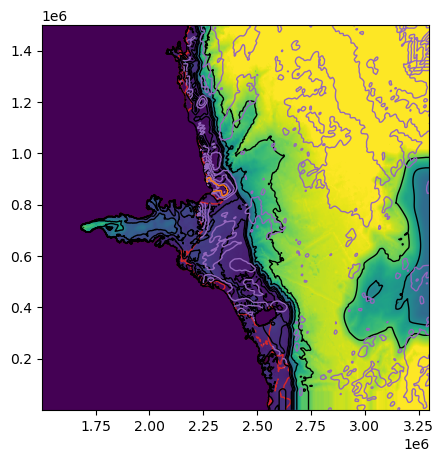

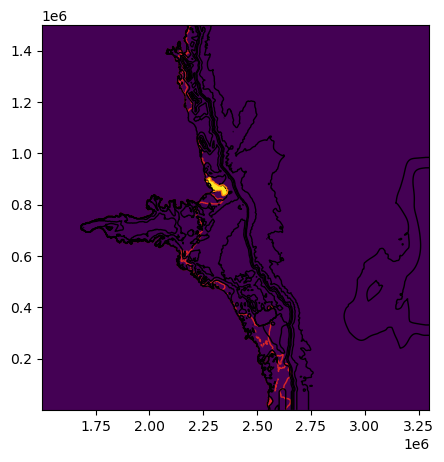

In [11]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r



# make grid masks


grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_openocean'] = grd.mask_rho*(grd.mask_zice==0)
grd['mask_openoceanNaN'] = grd.mask_openocean.where(grd.mask_openocean)
grd['mask_rhoNaN'] = grd.mask_rho.where(grd.mask_rho)
grd['mask_ziceNaN'] = grd.mask_zice.where(grd.mask_zice)

# amery mask

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])

mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])
grd['mask_zice_roi'] = grd.mask_zice*mask_roi
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

# polyna-center masks

ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


plotting=False
if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(ds.h*ds.mask_rho)
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    co2 = plt.contour(ds.h*ds.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
    plt.contour(swflux.mean(dim='swf_time')*ds.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)
    plt.plot(394,438,'x')
    plt.plot(364,393,'x')
    plt.plot(391,461,'x')
    plt.colorbar()
    plt.axis((300,500,250,500))

mask_burton_center = np.zeros_like(grd.lon_rho)
mask_burton_center[461:461+4,391:391+4]=1

mask_capedarnley_center = np.zeros_like(grd.lon_rho)
mask_capedarnley_center[437:437+4,393:393+4]=1

mask_mackenzie_center = np.zeros_like(grd.lon_rho)
mask_mackenzie_center[392:392+4,363:363+4]=1

mask_fasticetongue = np.zeros_like(grd.lon_rho)
mask_fasticetongue[400:425,367:425]=1
mask_fasticetongue = mask_fasticetongue*grd.mask_zice

if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(mask_fasticetongue*ds.zice,vmin=-10,vmax=0)
    plt.colorbar()
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    plt.axis((300,500,250,500))


# make polynya-area masks


mask_capedarnley_tempo = np.zeros_like(grd.lon_rho)
mask_capedarnley_tempo[410:460,380:450]=1

plt.figure(figsize=(5,5))
plt.pcolormesh(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho)
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)

cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s
p = cs.get_paths()
v = p[0].vertices
x = v[:,0]
y = v[:,1]
mask_capedarnley_tempo2 = inpolygon(grd.x_rho.values, grd.y_rho.values, x, y)


plt.figure(figsize=(5,5))
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_capedarnley_tempo2*grd.mask_openocean)

mask_capedarnley = mask_capedarnley_tempo2*grd.mask_openocean
grd['mask_capedarnley'] = mask_capedarnley
# define weighting parameters

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"



### finished preliminary loading data

In [12]:
# define time periods
winter_period=slice(51,64)
summer_period=slice(14,27)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period)[-1].values)

winter_period_doy=slice(49,62)
summer_period_doy=slice(12,25)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[-1].values)


late_summer_period=slice(20,80)
early_seaice_period=slice(80,130)
seaice_period=slice(130,330)
early_summer_period1=slice(330,366)
early_summer_period2=slice(0,20)



256  to  316
71  to  131
246  to  306
61  to  121


| Day | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|  1  |  32 |  60 |  91 | 121 | 152 | 182 | 213 | 244 | 274 | 305 | 335 |     |
|  2  |  33 |  61 |  92 | 122 | 153 | 183 | 214 | 245 | 275 | 306 | 336 |     |
|  3  |  34 |  62 |  93 | 123 | 154 | 184 | 215 | 246 | 276 | 307 | 337 |     |
|  4  |  35 |  63 |  94 | 124 | 155 | 185 | 216 | 247 | 277 | 308 | 338 |     |
|  5  |  36 |  64 |  95 | 125 | 156 | 186 | 217 | 248 | 278 | 309 | 339 |     |
|  6  |  37 |  65 |  96 | 126 | 157 | 187 | 218 | 249 | 279 | 310 | 340 |     |
|  7  |  38 |  66 |  97 | 127 | 158 | 188 | 219 | 250 | 280 | 311 | 341 |     |
|  8  |  39 |  67 |  98 | 128 | 159 | 189 | 220 | 251 | 281 | 312 | 342 |     |
|  9  |  40 |  68 |  99 | 129 | 160 | 190 | 221 | 252 | 282 | 313 | 343 |     |
| 10  |  41 |  69 | 100 | 130 | 161 | 191 | 222 | 253 | 283 | 314 | 344 |     |
| 11  |  42 |  70 | 101 | 131 | 162 | 192 | 223 | 254 | 284 | 315 | 345 |     |
| 12  |  43 |  71 | 102 | 132 | 163 | 193 | 224 | 255 | 285 | 316 | 346 |     |
| 13  |  44 |  72 | 103 | 133 | 164 | 194 | 225 | 256 | 286 | 317 | 347 |     |
| 14  |  45 |  73 | 104 | 134 | 165 | 195 | 226 | 257 | 287 | 318 | 348 |     |
| 15  |  46 |  74 | 105 | 135 | 166 | 196 | 227 | 258 | 288 | 319 | 349 |     |
| 16  |  47 |  75 | 106 | 136 | 167 | 197 | 228 | 259 | 289 | 320 | 350 |     |
| 17  |  48 |  76 | 107 | 137 | 168 | 198 | 229 | 260 | 290 | 321 | 351 |     |
| 18  |  49 |  77 | 108 | 138 | 169 | 199 | 230 | 261 | 291 | 322 | 352 |     |
| 19  |  50 |  78 | 109 | 139 | 170 | 200 | 231 | 262 | 292 | 323 | 353 |     |
| 20  |  51 |  79 | 110 | 140 | 171 | 201 | 232 | 263 | 293 | 324 | 354 |     |
| 21  |  52 |  80 | 111 | 141 | 172 | 202 | 233 | 264 | 294 | 325 | 355 |     |
| 22  |  53 |  81 | 112 | 142 | 173 | 203 | 234 | 265 | 295 | 326 | 356 |     |
| 23  |  54 |  82 | 113 | 143 | 174 | 204 | 235 | 266 | 296 | 327 | 357 |     |
| 24  |  55 |  83 | 114 | 144 | 175 | 205 | 236 | 267 | 297 | 328 | 358 |     |
| 25  |  56 |  84 | 115 | 145 | 176 | 206 | 237 | 268 | 298 | 329 | 359 |     |
| 26  |  57 |  85 | 116 | 146 | 177 | 207 | 238 | 269 | 299 | 330 | 360 |     |
| 27  |  58 |  86 | 117 | 147 | 178 | 208 | 239 | 270 | 300 | 331 | 361 |     |
| 28  |  59 |  87 | 118 | 148 | 179 | 209 | 240 | 271 | 301 | 332 | 362 |     |
| 29  |     |  88 | 119 | 149 | 180 | 210 | 241 | 272 | 302 | 333 | 363 |     |
| 30  |     |  89 | 120 | 150 | 181 | 211 | 242 | 273 | 303 | 334 | 364 |     |
| 31  |     |  90 |     | 151 |     | 212 | 243 |     | 304 |     | 365 |     |


In [13]:
%%time

# dump the big fields
ds_CTRL = ds_CTRL.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my'])
print(ds_CTRL.nbytes/1e9,'G')
ds_CTRL.load()

ds_AIS05 = ds_AIS05.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my'])
print(ds_AIS05.nbytes/1e9,'G')
ds_AIS05.load()

ds_AIS2 = ds_AIS2.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my'])
print(ds_AIS2.nbytes/1e9,'G')
ds_AIS2.load()

7.056273352 G
7.056273352 G
7.056273352 G
CPU times: user 20min 13s, sys: 16min 6s, total: 36min 19s
Wall time: 9min 8s


<xarray.Dataset> Size: 7GB
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 248B -0.9839 -0.9516 ... -0.01613
  * s_w                (s_w) float64 256B -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 5MB 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 5MB 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 5MB 1.502e+06 ... 3.298e+06
    y_u                (eta_rho, xi_u) float64 5MB 1e+03 1e+03 ... 1.499e+06
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 5MB 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 5MB -76.25 -76.23 ... -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 173MB 0.0 0.0 ... 0.0 0.0
    z_rho0             (s_rho, eta_rho, xi_rho) float64 167MB 0.0 0.0 ... -3.873
  * day                (day) int64 3kB 356 361 1 6 11 16 ... 331 336 341 346 351
  * dayofyear          (dayofyear) int64 584B 1 6 11 16 21 ... 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/93)
    ntimes             int32 4B 131400
    ndtfast            int32 4B 40
    dt                 float64 8B 240.0
    dtfast             float64 8B 6.0
    dstart             datetime64[ns] 8B 2007-01-01
    nHIS               int32 4B 1800
    ...                 ...
    dy_u               (eta_rho, xi_u) float64 5MB 2.018e+03 ... 1.889e+03
    dy_v               (eta_v, xi_rho) float64 5MB 2.018e+03 ... 1.889e+03
    dy_psi             (eta_v, xi_u) float64 5MB 2.018e+03 ... 1.889e+03
    dA                 (eta_rho, xi_rho) float64 5MB 4.073e+06 ... 3.574e+06
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 6GB nan .....
    my_doy             (dayofyear, eta_rho, xi_rho) float64 394MB nan ... nan
Attributes: (12/35)
    file:              roms_avg_0046.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Thursday - October 17, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

Text(0.5, 1.0, '$\\Delta$ Salinity')

<Figure size 640x480 with 0 Axes>

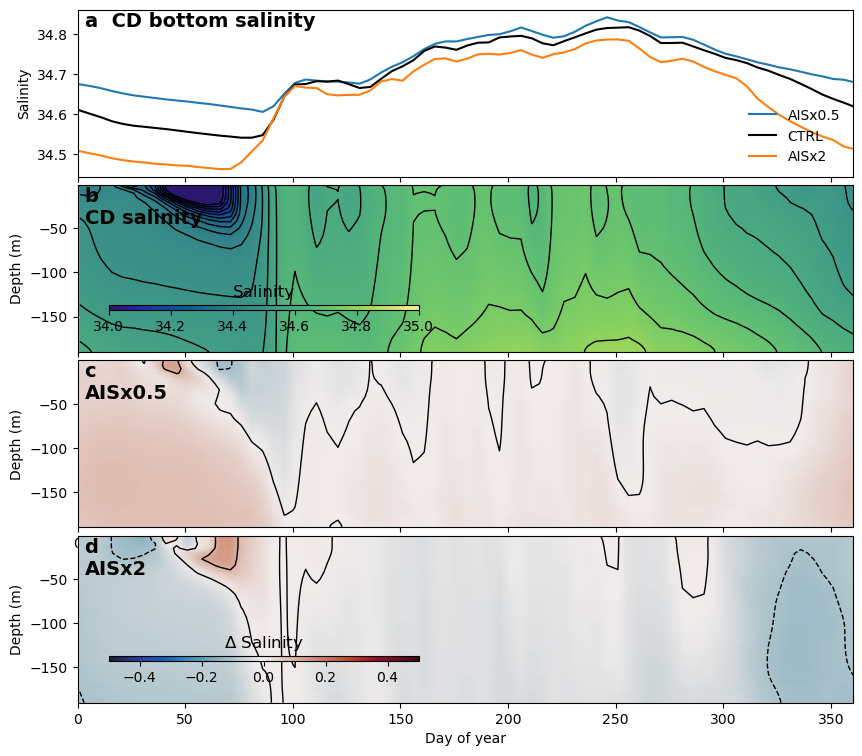

In [14]:
# now cape darnley salinity, but add a difference plot, and now take the average across multiple years.

gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.2, hspace=0.05,height_ratios=[.4,.4,.4,.4])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,9])
ax = None

ax=fig.add_subplot(gs[0,0])

ax.plot(ds_CTRL.dayofyear,ds_AIS05.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C0',linewidth=1.5,label='AISx0.5')
ax.plot(ds_CTRL.dayofyear,ds_CTRL.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='k',linewidth=1.5,label='CTRL')
# ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='No-AIS')
ax.plot(ds_CTRL.dayofyear,ds_AIS2.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C1',linewidth=1.5,label='AISx2')
# ax.plot(ds_CTRL.dayofyear,ds_AIS0.salt_doy.isel(s_rho=0).where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),color='C2',linewidth=1.5,label='No-AIS')
# ax.legend(frameon=False)
ax.text(0.01, 0.99, 'a  CD bottom salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.legend(frameon=False,loc='lower right')
ax.set_title('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Salinity')
ax.set_xlim((0,360))


ax=fig.add_subplot(gs[1,0])

CTRL =  ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T


im0=plt.pcolormesh(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
              CTRL,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
# plt.colorbar()
plt.contour(ds_CTRL.dayofyear,ds_CTRL.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               CTRL,
            levels=np.arange(34.0,35.0,0.05),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'b \nCD salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Depth (m)')
ax.set_xlim((0,360))

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im0, cax=cax, orientation='horizontal') 
cax.set_title(r'Salinity')

ax=fig.add_subplot(gs[2,0])
im=plt.pcolormesh(ds_AIS05.dayofyear,ds_AIS05.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS05.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS05.dayofyear,ds_AIS05.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS05.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'c \nAISx0.5', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.set_xlim((0,360))

ax=fig.add_subplot(gs[3,0])
im=plt.pcolormesh(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,shading='gouraud',
              cmap='cmo.balance',vmin=-.5,vmax=.5)
# plt.colorbar()
plt.contour(ds_AIS2.dayofyear,ds_AIS2.z_rho0.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).T-CTRL,
            levels=np.arange(-.5,.5,.1),colors='k',linewidths=1)
ax.text(0.01, 0.99, 'd \nAISx2', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('Day of year')
ax.set_ylabel('Depth (m)')
ax.set_xlim((0,360))

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ Salinity')



### red is +ve: sens is saltier than ctrl, ctrl is fresher than sens.
## blue is -ve: sens is fresher than ctrl, ctrl is saltier than sens.

In [15]:
ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).sel(dayofyear=winter_period_doy).mean(dim='dayofyear')

<xarray.DataArray 'salt_doy' ()> Size: 8B
array(34.46906333)
Coordinates:
    s_rho    float64 8B -0.9839

In [16]:
print(ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy).values)

print(ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values)
print(ds_AIS05.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values)
print(ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values)


[246 251 256 261 266 271 276 281 286 291 296 301 306]
34.738779539925815
34.79321918115702
34.77954950557792


In [17]:
print('salinity difference')
print(ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values - ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values)
print(ds_AIS05.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values - ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values)


salinity difference
-0.040769965652103224
0.013669675579102147


In [18]:
#\frac{exp_{new} - exp_{ctrl}}{exp_{ctrl}}
print('percentage change')
winter_salt_mean = ds_CTRL.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values
winter_salt_mean_ais05 = ds_AIS05.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values
winter_salt_mean_ais2 = ds_AIS2.salt_doy.where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho')).isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values

print((winter_salt_mean_ais05 - winter_salt_mean)/ winter_salt_mean)
print((winter_salt_mean_ais2 - winter_salt_mean)/ winter_salt_mean)


percentage change
0.00039303774124244524
-0.0011722396129818923


In [19]:
# calculate mean of annual salt variation.
salt_mn = (ds_CTRL.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_mn)
salt_std = (ds_CTRL.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).std(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_std)

salt_mn_ais2 = (ds_AIS2.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_mn_ais2)
salt_std_ais2 = (ds_AIS2.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).std(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_std_ais2)

salt_mn_ais05 = (ds_AIS05.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_mn_ais2)

34.77954947995089
0.030341309491044733
34.73877946031871
0.03474740347242751
34.73877946031871


In [20]:
#z-score = new_value - ctr_mean_value / ctrl_std
print('Calculate z-scores')
print((salt_mn_ais2 - salt_mn )/salt_std)
print((salt_mn_ais05 - salt_mn )/salt_std)


Calculate z-scores
-1.3437132515394656
0.45053150795837854


Now get melt statistics

In [21]:
# calculate mean of annual salt variation.
print('winter means')
melt_mn = (ds_CTRL.my_doy.isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(melt_mn)
melt_std = (ds_CTRL.my_doy.isel(dayofyear=winter_period_doy).std(dim='dayofyear').where(mask_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(melt_std)

melt_mn_ais2 = (ds_AIS2.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(melt_mn_ais2)
melt_std_ais2 = (ds_AIS2.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).std(dim='dayofyear').where(mask_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(melt_std_ais2)

melt_mn_ais05 = (ds_AIS05.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(melt_mn_ais05)

print('annual means')
melt_mn = (ds_CTRL.my_doy.mean(dim='dayofyear').where(mask_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(melt_mn)
melt_std = (ds_CTRL.my_doy.std(dim='dayofyear').where(mask_roi==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(melt_std)

winter means
0.5559727984202317
0.08332582142528042
34.54739557649655
0.003755618816725127
34.5960078239325
annual means
0.669571823441824
0.25245825783180736
